In [1]:
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib as mpl
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
from scipy.stats import bootstrap
import statsmodels.api as sm
import statsmodels.formula.api as smf

params = {
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "text.usetex": False,
}

mpl.rcParams.update(params)


import warnings

warnings.filterwarnings("ignore")


In [ ]:
df_time_series = pd.read_csv(
    "./data/df_timeseries_en.tsv.gz", compression="infer", sep="\t"
)
df_time_series["datetime"] = pd.to_datetime(df_time_series["datetime"])

df_channels = pd.read_csv("./data/df_channels_en.tsv.gz", compression="infer", sep="\t")
df_channels["join_date"] = pd.to_datetime(df_channels["join_date"])


In [2]:
video_metadatas = pd.read_feather(
    "./data/yt_metadata_helper.feather",
    columns=[
        "categories",
        "upload_date",
        "duration",
        "like_count",
        "dislike_count",
        "view_count",
        "channel_id",
    ],
)


In [ ]:
# round the subs value, easier to consider 1 sub as a person and not half of a person...
df_time_series.subs = df_time_series.subs.round(0)


In [ ]:
df_time_series.head()


In [ ]:
df_channels.head()


In [ ]:
video_metadatas.head()


# Check length of videos

An idea would be to use cut to match length of videos into discrete intervals 

In [ ]:
video_metadatas.duration.describe()


In [ ]:
# To make it easier to grasp the length of videos, we will convert the lengths to minutes at first...
video_metadatas["duration_min"] = video_metadatas["duration"] / 60
video_metadatas.duration_min.describe()


In [ ]:
plt.boxplot(video_metadatas["duration_min"], showfliers=False, vert=False)
plt.title("Duration of Videos in Minutes")


In [ ]:
duration_min_cumul = plt.hist(
    video_metadatas.duration_min, bins=100, log=True, cumulative=-1, histtype="step"
)
plt.title("Histogram of Duration for YouTube Videos (cumulative)")
plt.ylabel("# of Videos (in log scale)")
plt.xlabel("Duration in Minutes")
plt.xticks(rotation=30, ha="right")
plt.show()


In [ ]:
plt.loglog(duration_min_cumul[1][1:], duration_min_cumul[0])
plt.title("Histogram of Duration for YouTube Videos (cumulative)")
plt.ylabel("# of Videos (in log scale)")
plt.xlabel("Duration")
plt.xticks(rotation=30, ha="right")
plt.show()


In [ ]:
# long to compute

# bucket_durations = pd.cut(video_metadatas['duration'], bins=100)
# print(type(bucket_durations))


---

# Check frequency of videos

In [ ]:
video_count = (
    video_metadatas.groupby(pd.Grouper(key="upload_date", freq="W")).count().channel_id
)


In [ ]:
plt.plot(video_count, color="#7570b3", ls="--", label="\% videos uploaded")
plt.yscale("log")
plt.ylabel("Number of Videos")
plt.xlabel("Time")
plt.title("Number of videos updated each week")


In [ ]:
# now we will determine how many videos are uploaded to YouTube by each channel by year
video_metadatas["yearNumber"] = video_metadatas["upload_date"].dt.year
vd_cnt_by_id_yr = (
    video_metadatas.groupby(["channel_id", "yearNumber"])
    .count().categories.unstack().reset_index()
)
vd_cnt_by_id_yr.columns.name = None

In [ ]:
# we now remove the channels that uploaded less than 12 videos throughout the study period
vd_cnt_by_id_yr_filtered = vd_cnt_by_id_yr[vd_cnt_by_id_yr.sum(axis=1)>12]

In [ ]:
vd_cnt_by_id_yr_filtered_summary = vd_cnt_by_id_yr_filtered.describe()

In [ ]:
plt.fill_between(x=list(vd_cnt_by_id_yr_filtered_summary.columns.values),
                y1=list(vd_cnt_by_id_yr_filtered_summary.loc["25%",:]),
                y2=list(vd_cnt_by_id_yr_filtered_summary.loc["75%",:]), 
                 alpha = 0.5, color = 'gray')
plt.plot(vd_cnt_by_id_yr_filtered_summary.loc["50%",:], color = 'black')

plt.xlabel('Year')
plt.ylabel('Yearly Upload Frequency')
plt.title('The quantiles of yearly video upload frequency')
# here we choose quantiles, since mean would be significantly affected by the extremely high yearly upload rates

---

# How long to reach 1M subscribers 

Could be interesting to take all the videos with 10K, 20K, 30K, ... and see the evolution to reach 100K for example. And compare different evolution : from 50K to 100K or from 500K to 600K, etc.. which one is the fastest, easiest ?  

In [ ]:
def get_df_channel_ascension(start_subs, end_subs):
    """finds the channels in the time series that have less than the start_subs and more than end_subs.
    It means that it begins with less than start_subs and have now at least end_subs

    Args:
        start_subs (float): low_threshold
        end_subs (float): high_threshold

    Returns:
        dataframe containing all the channels with evolution from starts_subs to end_subs
    """
    under_start_subs = df_time_series[df_time_series["subs"] < start_subs]
    more_end_subs = df_time_series[df_time_series["subs"] > end_subs]
    channel_start_to_end = df_time_series[
        df_time_series.channel.isin(under_start_subs.channel)
        & df_time_series.channel.isin(more_end_subs.channel)
    ]
    return channel_start_to_end


In [ ]:
def get_mean_time_to_reach_X_subs(df, lower_bound, upper_bound):
    time_to_reach_X_subs = df.groupby("channel").apply(
        lambda group: pd.Series(
            {
                "from_zero_to_hero_duration": group[group.subs > upper_bound][
                    "datetime"
                ].iloc[0]
                - group[group.subs < lower_bound]["datetime"].iloc[-1]
            }
        )
    )
    return time_to_reach_X_subs


In [ ]:
channel_10K_to_1M = get_df_channel_ascension(10_000, 1_000_000)
print(
    "We have {} channels that begins with 10K subs and reach at least 1M".format(
        channel_10K_to_1M.channel.nunique()
    )
)


In [ ]:
first_channel = channel_10K_to_1M.iloc[0]
test = channel_10K_to_1M[channel_10K_to_1M["channel"] == first_channel.channel]
# test = test[(test['datetime'] > np.datetime64('2018-07-20')) & (test['datetime'] < np.datetime64('2019-01-20'))]
test.plot(x="datetime", y="subs")
print("There are {} weeks for this channel".format(test.shape[0]))
print(
    "We should have approximately the same value : \n{} and {}".format(
        7 * test.shape[0], test.iloc[-1].datetime - test.iloc[0].datetime
    )
)


In [ ]:
# get the time it takes to go from less than 10K to 1M
time_to_reach_1M = get_mean_time_to_reach_X_subs(channel_10K_to_1M, 10_000, 1_000_000)
time_to_reach_1M.head()


In [ ]:
print(
    "In average YTbers take {} days to reach 1M of subscribers".format(
        time_to_reach_1M["from_zero_to_hero_duration"].mean().days
    )
)


It would be nice to bootstrap this result to see with interval of confidence the time taken by Youtuber to reach 1M

In [ ]:
data = time_to_reach_1M["from_zero_to_hero_duration"].apply(
    lambda delta_time: delta_time.days
)


In [ ]:
rng = np.random.default_rng()
conf_interval_reach_1M = bootstrap(
    (data,),
    np.mean,
    confidence_level=0.95,
    random_state=rng,
).confidence_interval
conf_interval_reach_1M


In [ ]:
print(
    "The 95% interval of confidence, the time taken to reach 1M (from 10K) is [{}, {}]".format(
        conf_interval_reach_1M.low, conf_interval_reach_1M.high
    )
)


---

# Check the number of views (maybe after we could add likes, dislike) given a certain categories and date of videos

For this task lets analyze and after ploting and getting some intuition, use logistic regression to 'predict' the nb of views given category and date 

In [ ]:
video_metadatas.head()
video_metadatas.shape


In [ ]:
# I added this [:] to make a copy of the video_metadatas, so that the following operation wont affect the original video_metadatas
videos_with_cat = video_metadatas[:]
# here I tried to use the same expression as the replace you used below but it doesnt seem to work...
videos_with_cat["categories"] = videos_with_cat["categories"].apply(lambda x: x.replace(" & ", "_"))
# delete the rows with empty categories
videos_with_cat.categories.replace("", np.nan, inplace=True)
videos_with_cat.dropna(subset=["categories"], inplace=True)
videos_with_cat.shape

In [ ]:
encoded_cat = pd.get_dummies(videos_with_cat.categories)
video_metadatas_encoded = videos_with_cat.join(encoded_cat)

In [ ]:
video_metadatas_encoded["year"] = video_metadatas_encoded["upload_date"].dt.year

In [ ]:
mean_views = video_metadatas_encoded.groupby(["year", "categories"]).apply(
    lambda x: pd.Series({"mean_view": x.view_count.mean()})
)


In [ ]:
mean_views[:10]


In [ ]:
# see the top most viewed categories every year
largest_cat_every_year = (
    mean_views.groupby("year")["mean_view"].nlargest(2).droplevel(0)
)
largest_cat_every_year[:10]


In [ ]:
# Wenxiu Comment: This prediction simply shows which categories have a higher view counts. Can't this be shown by simply comparing
# the view count evolution across different categories across years? Also the number of like and dislikes are directly linked
# to the view count, as one would have to view the video before rating like or dislike - does it still make it suitable to be considered?
# also maybe we can add positiveness and negativeness of titles and so on for the model?

# one reasonable prediction I can think of is to use the time series data to predict subscription.

model = smf.ols(
    formula='view_count ~ year + duration + C(Autos_Vehicles) + C(Comedy) + C(Education) + C(Entertainment) + C(Film_Animation) + \
                C(Gaming) + C(Movies) + C(Music) + C(News_Politics) + C(Nonprofits_Activism) + \
                C(People_Blogs) + C(Pets_Animals) + C(Science_Technology) + C(Shows) + C(Sports) + C(Travel_Events)',
    data=video_metadatas_encoded
)

res = model.fit()
print(res.summary())

In [ ]:
# Alternatively, I suggest the following to determine which type of videos are more popular
# now we will determine how many videos are uploaded to YouTube by each channel by year
video_count_by_year = videos_with_cat.dropna(axis=0).groupby(["categories", "yearNumber"]).sum()
# NOTE THAT CATEGORIES::MOVIES AND SHOWS HAVE VERY FEW DATA!

In [ ]:
video_view_count_by_year = video_count_by_year.view_count.unstack().reset_index()
video_view_count_by_year.columns.name = None

video_like_count_by_year = video_count_by_year.like_count.unstack().reset_index()
video_like_count_by_year.columns.name = None

video_dislike_count_by_year = video_count_by_year.dislike_count.unstack().reset_index()
video_dislike_count_by_year.columns.name = None

In [ ]:
videos_with_cat.loc[videos_with_cat["categories"]=="Movies", ]

In [ ]:
plt.rcParams["figure.figsize"] = (15,10)
for i in np.arange(video_view_count_by_year.shape[0]) :
    plt.plot(video_view_count_by_year.loc[i,][2:], label=video_view_count_by_year.loc[i,][0:1][0])
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("video view count")
plt.title("video view counts per year for each category")
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (15,10)
for i in np.arange(video_like_count_by_year.shape[0]) :
    plt.plot(video_like_count_by_year.loc[i,][2:], label=video_like_count_by_year.loc[i,][0:1][0])
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("video likes count")
plt.title("video likes counts per year for each category")
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (15,10)
for i in np.arange(video_dislike_count_by_year.shape[0]) :
    plt.plot(video_dislike_count_by_year.loc[i,][2:], label=video_dislike_count_by_year.loc[i,][0:1][0])
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("video dislikes count")
plt.title("video dislikes counts per year for each category")
plt.show()

In [ ]:
# NORMALISATION:
## 1. view count - normalise wrt. total video views per year, to see which categories is viewed more every year
plt.rcParams["figure.figsize"] = (15,10)
for i in np.arange(video_view_count_by_year.shape[0]) :
    plt.plot(video_view_count_by_year.loc[i,][2:]/video_view_count_by_year.sum(axis=0)[2:], 
             label=video_view_count_by_year.loc[i,][0:1][0])
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("NORMALISED: video view count")
plt.title("NORMALISED: video view counts per year for each category")
plt.show()
# view on music videos decreases, whereas on entertainment and gaming increases

In [ ]:
## 2. like count - normalise wrt. total likes+dislikes for that category for that year
plt.rcParams["figure.figsize"] = (15,10)
for i in np.arange(video_like_count_by_year.shape[0]) :
    plt.plot(video_like_count_by_year.loc[i,][2:]/(video_like_count_by_year.loc[i,][2:]+video_dislike_count_by_year.loc[i,][2:]), 
             label=video_like_count_by_year.loc[i,][0:1][0])
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("NORMALISED: video likes count")
plt.title("NORMALISED: video likes counts per year for each category")
plt.show()

# now it is interesting to see that news_politics and education are consistantly less liked
# whereas for nonprofits_activism is becoming more loved

In [ ]:
top_ranked_channels = df_channels[df_channels.subscriber_rank_sb < 100]
top_ranked_channels.head()

In [ ]:
date = top_ranked_channels["join_date"].apply(lambda d: d.to_pydatetime().year)
np.mean(date, axis=0)


In [ ]:
oldest_video = df_channels["join_date"].apply(lambda d: d.to_pydatetime().year)
oldest_video.nsmallest(5)

In [ ]:
channels_with_largest_subscribers = df_channels.nlargest(53, "subscribers_cc")
channels_with_largest_subscribers.sample(7)


In [ ]:
dfs = []

# Use Least Square to predict the number of views given the category and the date

In [ ]:
def choose_video_metadata_year(year):
    return video_metadatas[video_metadatas['year'] == year]

In [ ]:
video_metadatas["year"] = video_metadatas["upload_date"].dt.year

In [ ]:
video_metadatas.head()


In [ ]:
video_metadatas.columns


In [ ]:
video_metadatas_2005 = choose_video_metadata_year(2005)
video_metadatas_2005.drop(['upload_date', 'channel_id'], axis=1, inplace=True)
video_metadatas_2005.head() 

In [ ]:
model = smf.ols(
    formula='view_count ~ duration + C(categories)',
    data=video_metadatas_2005
)

res = model.fit()
print(res.summary())

# print(res.predict([120, 'Music']))


# Load the metada with titles and count the number of words 

In [3]:
import re
# we need to improve the hw1 method a bit because we want to make sure that titles with a lot of spaces 
# don't have too many words and if there is a type (e.g "Welcome,in my video" is counted as 4 words and not 3)
def count_words_simple(x : str):
    new_x = x.replace(',', ' ')
    new_x = re.sub(' +', ' ', new_x)
    return len(new_x.split(' '))

In [15]:
print(count_words_simple('Salut     je suis la'))
print(count_words_simple('Salut,je suis la'))

4
4


In [5]:
titles_metadata = pd.read_feather(
    "./data/yt_metadata_title_helper.feather", columns=["title"]
)


In [6]:
titles_metadata.head()

,title
0,Lego City Police Lego Firetruck Cartoons about...
1,Lego Marvel SuperHeroes Lego Hulk Smash Iron-M...
2,Lego City Police Lego Fireman Cartoons about L...
3,Lego Harry Potter Complete Lego New Movie for ...
4,Lego City Police 1 HOUR LONG VIDEO for kids Le...


In [7]:
video_metadatas.head()

,categories,upload_date,duration,like_count,dislike_count,view_count,channel_id
0,Film & Animation,2016-09-28,1159,8.0,1.0,1057.0,UCzWrhkg9eK5I8Bm3HfV-unA
1,Film & Animation,2016-09-28,2681,23.0,1.0,12894.0,UCzWrhkg9eK5I8Bm3HfV-unA
2,Film & Animation,2016-09-28,1394,1607.0,779.0,1800602.0,UCzWrhkg9eK5I8Bm3HfV-unA
3,Film & Animation,2016-09-28,5064,227.0,24.0,57640.0,UCzWrhkg9eK5I8Bm3HfV-unA
4,Film & Animation,2016-09-28,3554,105.0,13.0,86368.0,UCzWrhkg9eK5I8Bm3HfV-unA


In [ ]:
# titles_metadata.drop('categories', axis=1, inplace=True)
# titles_metadata

In [8]:
titles_nb_words = titles_metadata
titles_nb_words.title = titles_metadata['title'].apply(lambda x : count_words_simple(x))

In [9]:
titles_nb_words.rename(columns={'title' : 'nb_words'}, inplace=True)

In [10]:
video_metadatas_titles = pd.concat([titles_nb_words, video_metadatas], axis=1, ignore_index=False)

In [31]:
video_metadatas_titles.sample(7)

,nb_words,categories,upload_date,duration,like_count,dislike_count,view_count,channel_id
66393156,17,People & Blogs,2017-08-14,240,20331.0,594.0,1321482.0,UC2AtG9Ewa5o7O0wWuaDIfmA
12066403,13,People & Blogs,2014-10-16,3717,5.0,0.0,161.0,UCiYW6XlM19pD6Is4guL1r8Q
40856705,13,Howto & Style,2018-05-22,882,479.0,35.0,33130.0,UCM4vLyVm4MPhS3o5o729Udg
70485789,9,People & Blogs,2018-03-29,112,59.0,0.0,1088.0,UCtmfnlrM4zlHfbwNvWqJmtA
57419185,8,Music,2016-08-18,5,1521.0,15.0,116108.0,UC9ecwl3FTG66jIKA9JRDtmg
7383549,7,News & Politics,2015-11-07,948,5.0,0.0,1040.0,UCmKypNsPUqQ-3UWb1cyDs4Q
13208913,10,Music,2017-01-09,7739,31.0,0.0,730.0,UChcG7ngevi1XoxAKR1Wkfow


In [34]:
videos_per_nb_words = video_metadatas_titles.groupby('nb_words')['view_count'].size()
videos_per_nb_words

nb_words
1      400834
2      994850
3     2303185
4     3685433
5     5190945
6     6389719
7     7118002
8     7354377
9     7131602
10    6437054
11    5626406
12    4813039
13    4005824
14    3313926
15    2684118
16    2049974
17    1466324
18     950593
19     543797
20     271268
21     123514
22      46152
23      15675
24       4851
25       1722
26        615
27        375
28        190
29         90
30         74
31         56
32         36
33         31
34         25
35         18
36         20
37         14
38         30
39          7
40          7
41          3
42          6
43          4
44          4
46          1
48          1
49          1
50          1
51          1
Name: view_count, dtype: int64

we delete the group with less than a thresholds since it biases the graph (After 23 words in the title there are not enough videos to have consistent results)

In [40]:
view_mean_per_nb_words = video_metadatas_titles.groupby('nb_words')['view_count'].mean()[:23]
view_mean_per_nb_words

nb_words
1      57761.430057
2      77505.002560
3      99460.416482
4     113097.104902
5     115064.111389
6     121208.912504
7     124489.230125
8     121281.358678
9     121461.602119
10    121325.795567
11    120434.753202
12    117976.903298
13    122972.023209
14    133711.407122
15    147568.119316
16    160110.572982
17    181382.344847
18    199000.985793
19    216112.072264
20    255054.541935
21    227615.954215
22    213969.849216
23    208575.034131
Name: view_count, dtype: float64

In [68]:
view_mean_per_nb_words.index.values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23], dtype=int64)

# We have to be careful of YTbers with many views, if they have long titles it biases the result 

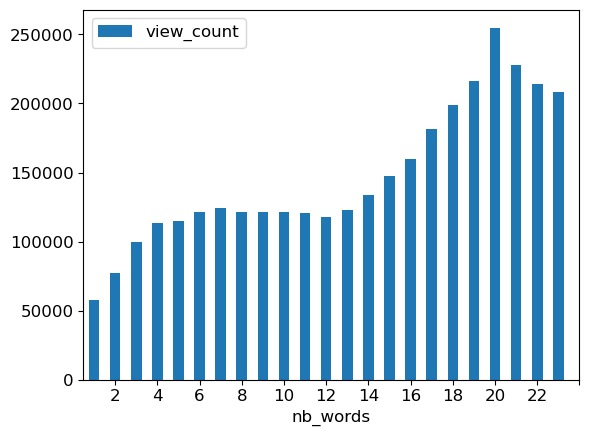

In [74]:
x_ticks = view_mean_per_nb_words.index.values[::2] 
ax = view_mean_per_nb_words.plot.bar(rot=0)
ax.set_xticks(x_ticks)
ax.legend()

In [ ]:
words_per_cat = video_metadatas_titles.groupby('categories').agg({'nb_words': 'mean'})

words_per_cat.nb_words

In [ ]:
words_per_cat.index

In [ ]:
print('The x axis is :\n', words_per_cat.index.values[1:])
plt.xticks(fontsize=6)
plt.bar([index[:5] for index in words_per_cat.index[1:]], words_per_cat.nb_words[1:])

---

In [ ]:
top_ranked_channels = df_channels[df_channels.subscriber_rank_sb < 100]
top_ranked_channels.head()


In [ ]:
date = top_ranked_channels["join_date"].apply(lambda d: d.to_pydatetime().year)
np.mean(date, axis=0)


In [ ]:
oldest_video = df_channels["join_date"].apply(lambda d: d.to_pydatetime().year)
oldest_video.nsmallest(5)


In [ ]:
channels_with_largest_subscribers = df_channels.nlargest(53, "subscribers_cc")
channels_with_largest_subscribers.sample(7)
